In [1]:
import json
import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import model
import evaluator
import time

import sys

from pathlib import Path

%matplotlib notebook

In [2]:
#!rm -r x86_64
#!nrnivmodl mechanisms

In [3]:
probe = None #model.define_electrode(probe_type="linear")

In [6]:
cell = model.create(morph_modifier="hillock", release=True)

param_names = [param.name for param in cell.params.values() if not param.frozen]

fitness_protocols = evaluator.define_protocols(
    feature_set=None, 
    feature_file=None, 
    electrode=probe,
    protocols_with_lfp=None
)

fitness_calculator = ephys.objectivescalculators.ObjectivesCalculator([])

sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe)

eva = ephys.evaluators.CellEvaluator(                    
        cell_model=cell,                                                       
        param_names=param_names,                                                    
        fitness_protocols=fitness_protocols,                                        
        fitness_calculator=fitness_calculator,                                      
        sim=sim)

In [7]:
fitness_protocols

{'bAP': <bluepyopt.ephys.protocols.SweepProtocol at 0x7fffb5d35ca0>,
 'BAC': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813cdb160>,
 'EPSP': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813cdb400>,
 'CaBurst': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813cdb670>,
 'Step1': <bluepyopt.ephys.protocols.SweepProtocol at 0x7ff813cdb8e0>}

In [8]:
t_start = time.time()
responses = eva.run_protocols(protocols=fitness_protocols.values(), param_values={})
print(f"Elapsed time: {time.time() - t_start}")

Elapsed time: 39.165398359298706


<IPython.core.display.Javascript object>


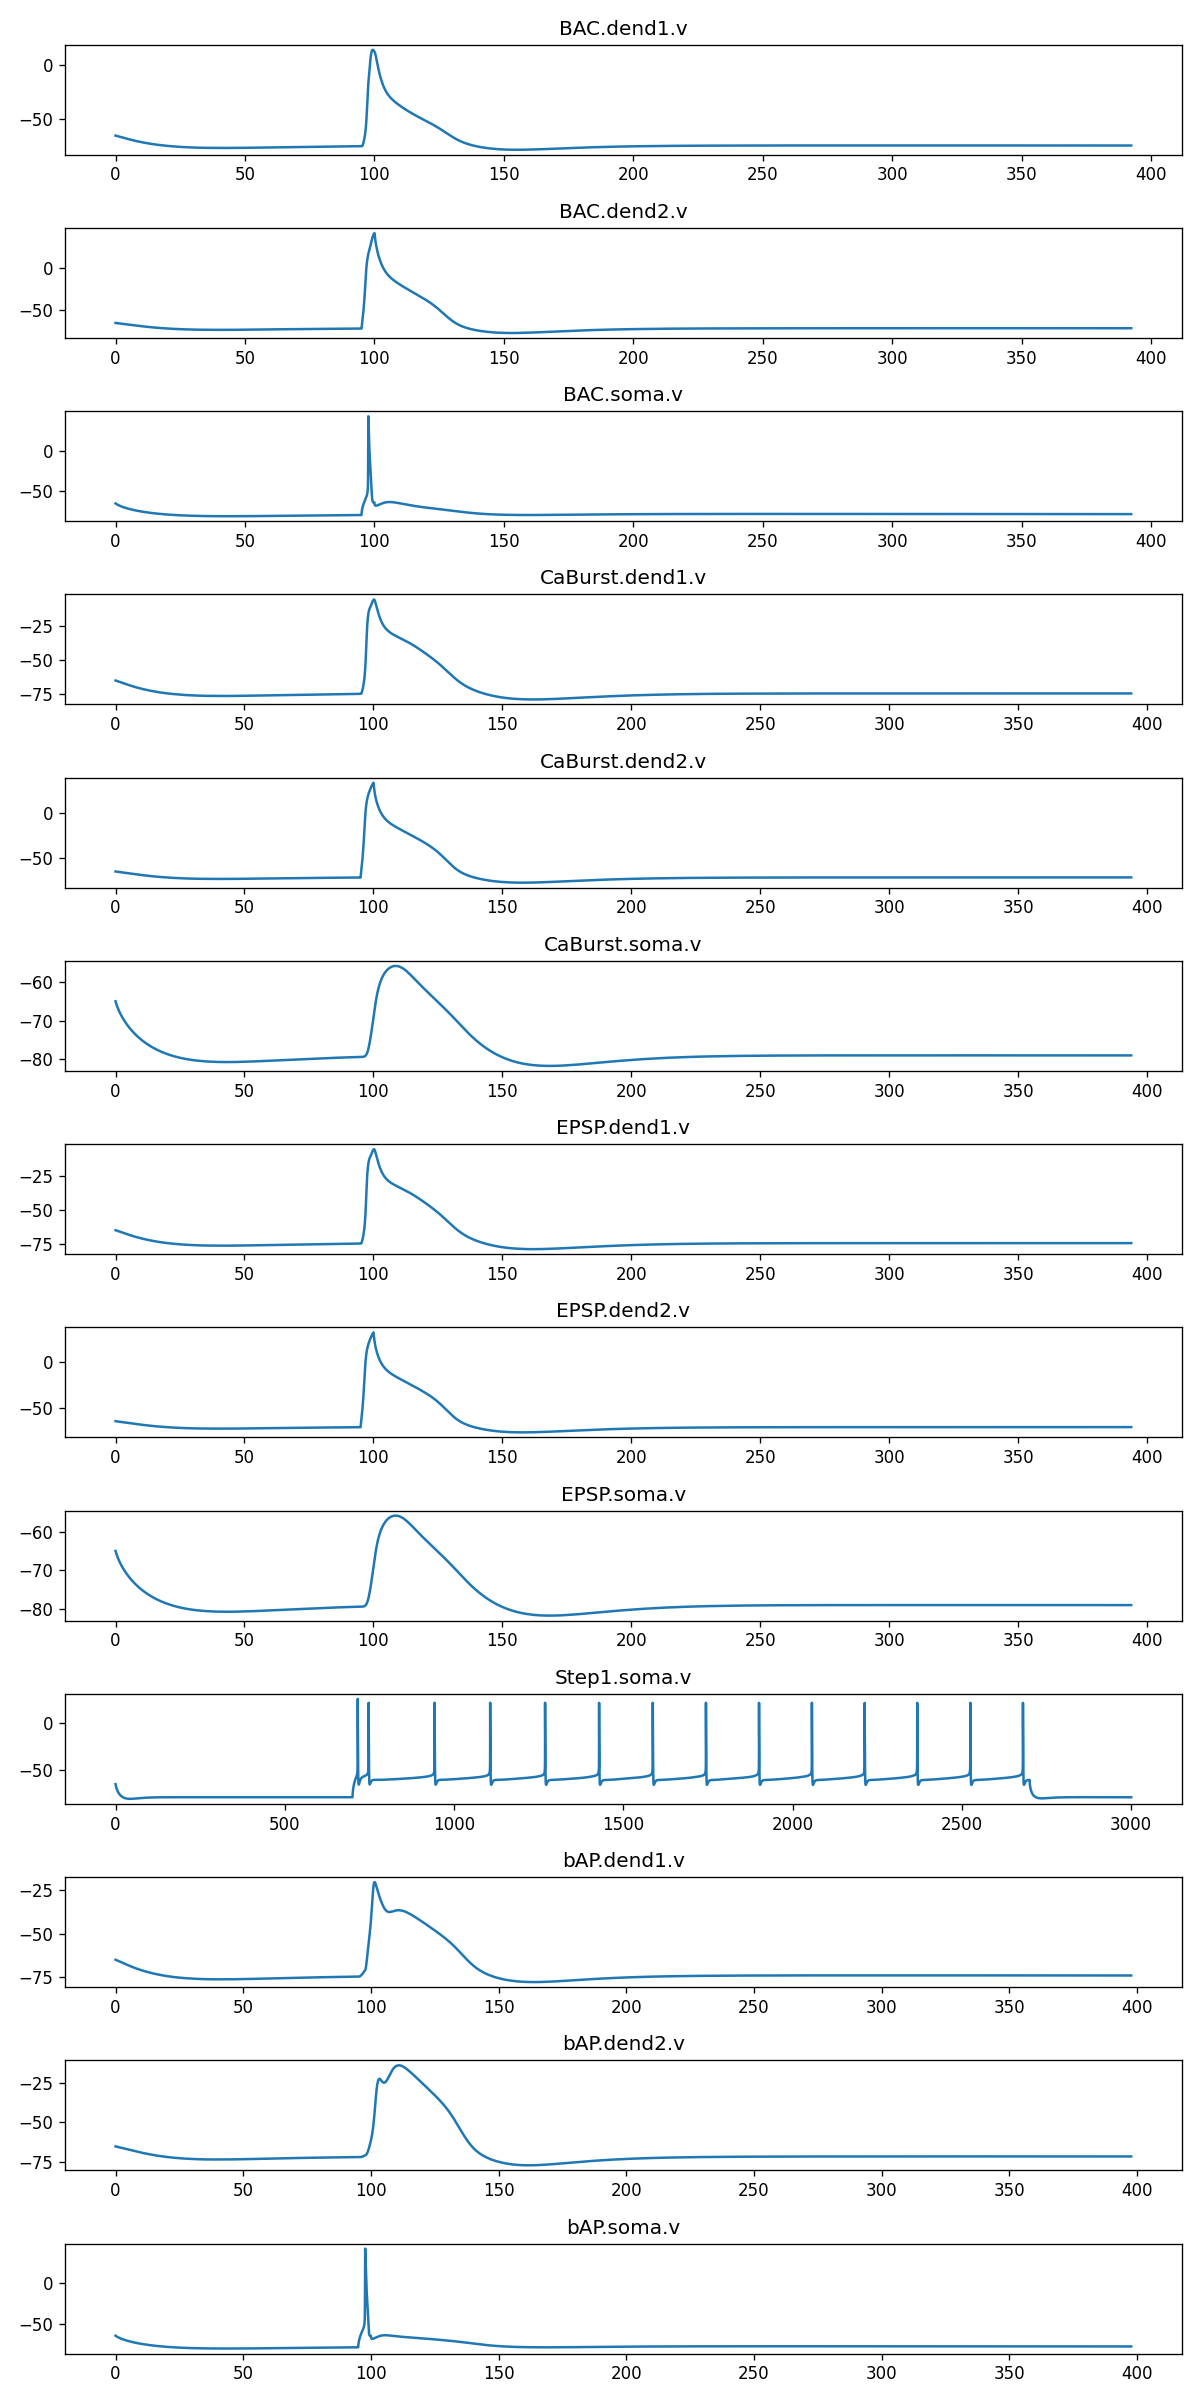

In [9]:
fig, axes = plt.subplots(len(responses), figsize=(10, 20), squeeze=False)
for index, (resp_name, response) in enumerate(sorted(responses.items())):
    axes[index, 0].plot(response['time'], response['voltage'], label=resp_name)
    axes[index, 0].set_title(resp_name)
fig.tight_layout()
fig.show()